In [1]:
#I am redoing this notebook since I lost it. 
# Reminder: Push to github more often, specialy when working on your old computer

from datasets import load_dataset, load_from_disk
import pandas as pd
import torch
import torch.nn.functional as F
from huggingface_hub import notebook_login
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, f1_score, ConfusionMatrixDisplay, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import os
from dotenv import load_dotenv

#Loading the environment variables
load_dotenv() 

PROJECT_DIR = os.getenv("PROJECT_DIR")
HUGGINGFACE_TOKEN = os.getenv("HUGGINGFACE_TOKEN")


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


### Fine-tuning transformer model

In [2]:
# loading the pretrained model, we are using AutoModelForSequenceClassification and not AutoModel
# because we are interested in the classification head of the model
#!!! Notice that the classification head is randomly initialized

num_labels = 6
model_ckpt = 'distilbert-base-uncased'

tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=num_labels).to(device)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [3]:
# Let's re-load the emotions dataset
#Tokenizing the whole dataset
def tokenize(batch):
    return tokenizer(batch['text'], padding=True, truncation=True)

#Load back the emotions dataset
emotions = load_dataset("emotion", trust_remote_code=True)
emotions_encoded = emotions.map(tokenize, batched=True, batch_size=None)

In [4]:
# metrics function for the Trainer

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1
    }

In [7]:
# log in to the huggingface hub
notebook_login(HUGGINGFACE_TOKEN)

In [8]:
#let's define the training arguments and the trainer

batch_size = 65
logging_steps = len(emotions_encoded['train']) // batch_size
model_name = f"{model_ckpt}-finetuned-emotions"
training_args = TrainingArguments(
    output_dir= os.path.join(PROJECT_DIR, "data/models", model_name),
    num_train_epochs=2,
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=0.01,
    eval_strategy='epoch',
    disable_tqdm=False,
    logging_steps=logging_steps,
    push_to_hub=True,
    log_level='error',
)

trainer = Trainer(
    model=model,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=emotions_encoded['train'],
    eval_dataset=emotions_encoded['validation'],
    tokenizer=tokenizer
)

# training the model
trainer.train()


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.808100,0.302724,0.906500,0.906481
2,0.246300,0.215319,0.924000,0.923973


TrainOutput(global_step=494, training_loss=0.5258128988115411, metrics={'train_runtime': 132.7656, 'train_samples_per_second': 241.026, 'train_steps_per_second': 3.721, 'total_flos': 720342861696000.0, 'train_loss': 0.5258128988115411, 'epoch': 2.0})

In [9]:
#Here I did not understand why one need to pass the tokenizer to the trainer, and how does the trainer
# knows which columns from the dataset to use for the input and the labels.

'''
From this page: https://huggingface.co/docs/transformers/main_classes/trainer

-  tokenizer (PreTrainedTokenizerBase, optional) — The tokenizer used to preprocess the data. 
If provided, will be used to automatically pad the inputs to the maximum length when batching inputs, 
and it will be saved along the model to make it easier to rerun an interrupted training or reuse the fine-tuned model. 

From this page: https://huggingface.co/docs/transformers/main_classes/model

- main_input_name (str) — The name of the principal input to the model (often input_ids for NLP models, pixel_values for 
vision models and input_values for speech models).

From this page: https://huggingface.co/docs/transformers/main_classes/tokenizer

-  model_input_names (List[string], optional) — The list of inputs accepted by the forward pass of the model 
(like "token_type_ids" or "attention_mask"). Default value is picked from the class attribute of the same name. 

'''

# Looks like the tokenizer is not needed as long as the dataset has the right columns, already tokenized
# Also looks like the tokenizer and the model already have defined the names of the input columns they expect

print(tokenizer.model_input_names)
print(model.main_input_name)

#It is strange thet one must pre-tokenize the dataset and then pas it to the trainer
# I tried to pass the original dataset and the tokenizer and it throws an error. 
# Maybe in next chapters we will be able to stack the tokenizer and the model in a pipeline (???)


['input_ids', 'attention_mask']
input_ids


{'test_loss': 0.21531900763511658, 'test_accuracy': 0.924, 'test_f1': 0.923972683017933, 'test_runtime': 2.0624, 'test_samples_per_second': 969.734, 'test_steps_per_second': 15.031}


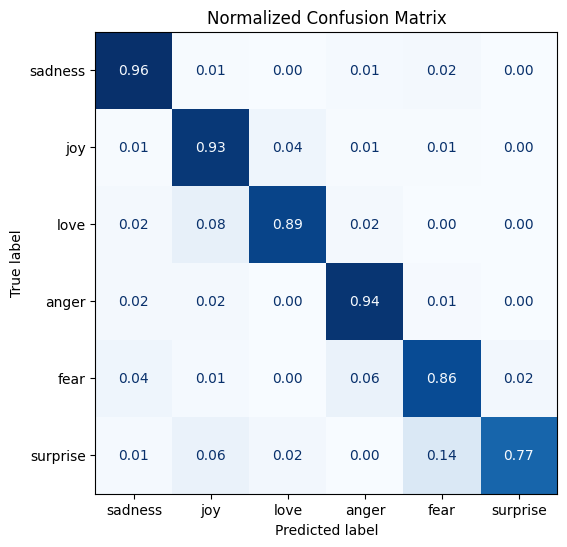

In [10]:
#plot confusion matrices
def plot_confusion_matrix(y_pred, y_true, labels):
    cm = confusion_matrix(y_true, y_pred, normalize='true')
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap='Blues', values_format='.2f', ax=ax, colorbar=False)
    plt.title('Normalized Confusion Matrix')
    plt.show()


# Let's displa the predictions
preds_output = trainer.predict(emotions_encoded['validation'])
print(preds_output.metrics)

# The predictions are logits!!!
labels = emotions['train'].features['label'].names
y_valid = emotions_encoded['validation']['label']
y_preds = np.argmax(preds_output.predictions, axis=1)

plot_confusion_matrix(y_preds, y_valid, labels)


### Error Analysis